# Grab land cover for specified extent
Say you want to grab land cover data for a specific location, but you don't want to download the entire NLCD dataset to do that. The ArcGIS Python API can help!

Here I present an example of doing just that. The steps involve:
1. [Prepping for the analysis: importing modules and authenticating our arcgis session](#1.-Prepping-for-analysis:-importing-and-authenticating)
2. [Searching for the land cover data **item** and creating a **imagery layer** from it](#2.-Searching-for-and-accessing-the-content)  
 2a. [Alternative: Fetching data by its item ID](#2a.-A-second-option-for-finding-and-fetching-data:-ESRI's-Living-Atlas)
3. [Accessing the layers contained in the image service](#3.-Accessing-the-layers-contained-in-the-image-service)  
 3a. [Accessing image services directly from their REST API URL](#3a.-Accesing-image-service-layers-directly,-using-their-REST-endpoint-URL)
4. [Exploring properties of the image layer](#4.-Exploring-properties-of-the-image-layer)
5. [Mapping](#5.Mapping)
6. [Subsetting our image](#6.-Subsetting-our-image)
7. [Getting the land cover at a specific location](#7.-Getting-the-land-cover-at-a-specific-location)

*Resource: https://developers.arcgis.com/python/guide/raster-analysis-advanced-concepts/*

## 1. Prepping for analysis: importing and authenticating
* Import the the arcgis `GIS` module. We're going to do some geocoding so we need to create the arcgis `geocoding` module as well. Lastly, enable the Jupyter `display` object

In [2]:
#Import the GIS object.  and display modules
from arcgis import GIS
#from arcgis.geocoding import geocode
from IPython.display import display, Image

* Authenticate our GIS object using our ArcGIS Pro account

In [3]:
#Create the GIS object, authenticating with your ArcGIS Pro account
gis = GIS('home')

## 2. Searching for and accessing the content
What we want is 2011 NLCD data, provided as an *image service* (i.e. as a raster). You could search for the data from within ArcGIS Pro or via the [ArcGIS Online](http://www.arcgis.com) website, but we'll do it right here. 

Like any web search, it's a bit of an art knowing how best to locate the resource you want. At play are what general search keywords to include, and specific categories like `owner` or `item-type` to invoke. We do, however, want to search outside the Duke Community, we we want to include `outside_org=True`. 

I've decided to use `NLCD 2011` as a general search term, filter results for only those that `esri` provides, and limit results to image services: 

In [4]:
#Search for land cover and print the number of results
nlcd_results = gis.content.search("NLCD 2011, owner:esri",   #The query used to select records
                                  item_type='Image Service', #Filter just those that are Imagery layers
                                  max_items=100,             #Default is 10 items; let's look for more
                                  outside_org=True)          #Default is to just search Duke's portal; turn that off
#Reveal how many hits we got
len(nlcd_results)

3

► This gives us several results, enough to show a list...

In [5]:
#Show a complete list of results
nlcd_results

[<Item title:"USA Cropland" type:Imagery Layer owner:esri>,
 <Item title:"USA NLCD Land Cover" type:Imagery Layer owner:esri>,
 <Item title:"USA NLCD Impervious Surface Time Series" type:Imagery Layer owner:esri>]

* The *second* item is the one we want. Let's store that as a variable named `lc_item`. 

In [6]:
#Get the second result and view what kind of Python object it is. 
nlcd_item = nlcd_results[1]
type(nlcd_item)

arcgis.gis.Item

In [7]:
#Show what kind of ArcGIS object it is
nlcd_item.type

'Image Service'

In [8]:
#Show what the item's ID is 
nlcd_item.id

'3ccf118ed80748909eb85c6d262b426f'

<Item title:"USA NLCD Land Cover" type:Imagery Layer owner:esri>
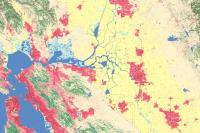

In [9]:
#Show the item info
nlcd_item

### 2a. A second option for finding and fetching data: ESRI's Living Atlas
ESRI's [Living Atlas](https://livingatlas.arcgis.com) contains a vast array of quality controlled data. Here's how we can access images hosted there: 
* Open the Living Atlas in your web browser. 
* Search for NLCD and select the [USA NLCD Land Cover](https://www.arcgis.com/home/item.html?id=3ccf118ed80748909eb85c6d262b426f)
* Note the Item ID in the page's URL: `3ccf118ed80748909eb85c6d262b426f`
* Fetch the imagery layer using this ID:

In [10]:
#Fetch the NLCD image layer service using its item ID
nlcd_item2 = gis.content.get('3ccf118ed80748909eb85c6d262b426f')
nlcd_item2.type

'Image Service'

<Item title:"USA NLCD Land Cover" type:Imagery Layer owner:esri>
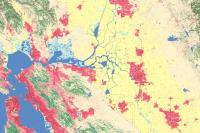

In [11]:
nlcd_item2

## 3. Accessing the <u>layers</u> contained in the image service
Image Services are a container for individual image layers. So to access the actual raster datasets we want to analyze or download, we need to drill into the service an pull out individual layers. 

In [12]:
#Reveal the layers associated with this service
nlcd_item.layers

[<ImageryLayer url:"https://landscape10.arcgis.com/arcgis/rest/services/USA_NLCD_Land_Cover/ImageServer">]

There's just the one layer. Let's extract it to a new variable...

In [13]:
#Captute the one and only layer as its own object and reveal its object type
nlcd_layer = nlcd_item.layers[0]
type(nlcd_layer)

arcgis.raster._layer.ImageryLayer

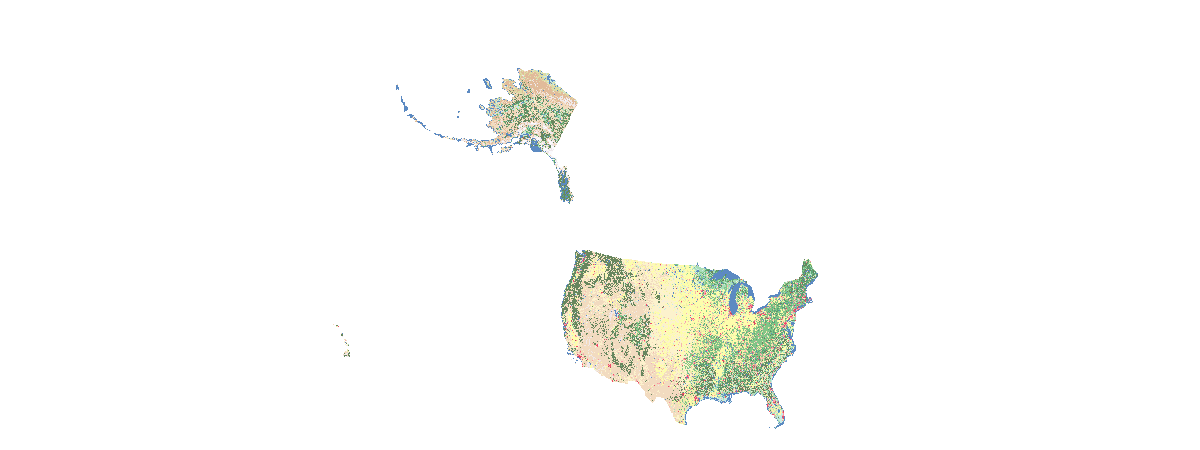

In [14]:
#Show the layer
nlcd_layer

### 3a. Accesing image service layers directly, using their REST endpoint URL
What if you couldn't find the item's ID? If you can find the service's REST endpoint, you can create an image layer from that. 
 * First you have to import the `ImagerLayer` object from the ArcGIS Python API's `raster` submodule. 
 * Then we create the image layer from the REST URL. 
 * In this instance, we have to supply the `gis` object because layers in the Living Atlas are restricted, meaning you have to provide an authenticated GIS object. 

In [15]:
#Import the ImageryLayer object into our session
from arcgis.raster import ImageryLayer

#Construct the layer directly from its URL
nlcd_layer2 = ImageryLayer(url='https://landscape10.arcgis.com/arcgis/rest/services/USA_NLCD_Land_Cover/ImageServer',
                           gis=gis)

## 4. Exploring properties of the image layer
Before analyzing our image, let's look at how we access its properties

In [16]:
#Show properties associated with the layer
list(nlcd_layer.properties.keys())

['currentVersion',
 'serviceDescription',
 'name',
 'description',
 'extent',
 'initialExtent',
 'fullExtent',
 'timeInfo',
 'pixelSizeX',
 'pixelSizeY',
 'bandCount',
 'pixelType',
 'minPixelSize',
 'maxPixelSize',
 'copyrightText',
 'serviceDataType',
 'minValues',
 'maxValues',
 'meanValues',
 'stdvValues',
 'objectIdField',
 'fields',
 'capabilities',
 'defaultMosaicMethod',
 'allowedMosaicMethods',
 'sortField',
 'sortValue',
 'sortAscending',
 'mosaicOperator',
 'maxDownloadSizeLimit',
 'defaultCompressionQuality',
 'defaultResamplingMethod',
 'maxImageHeight',
 'maxImageWidth',
 'maxRecordCount',
 'maxDownloadImageCount',
 'maxMosaicImageCount',
 'allowRasterFunction',
 'rasterFunctionInfos',
 'rasterTypeInfos',
 'mensurationCapabilities',
 'hasHistograms',
 'hasColormap',
 'hasRasterAttributeTable',
 'minScale',
 'maxScale',
 'exportTilesAllowed',
 'hasMultidimensions',
 'supportsStatistics',
 'supportsAdvancedQueries',
 'editFieldsInfo',
 'ownershipBasedAccessControlForRasters

In [17]:
#Show the fields
for f in nlcd_layer.properties.fields: print (f.name)

OBJECTID
Shape
Name
MinPS
MaxPS
LowPS
HighPS
Category
Tag
GroupName
ProductName
CenterX
CenterY
ZOrder
Shape_Length
Shape_Area
StartYear
EndYear


In [18]:
#Reveal the item's spatial reference
nlcd_layer.properties.spatialReference

{
  "wkid": 102008,
  "latestWkid": 102008
}

In [19]:
#What are the pixel sizes in the X and Y direction? 
xPixelSize = nlcd_layer.properties.pixelSizeX
yPixelSize = nlcd_layer.properties.pixelSizeY
print(xPixelSize,yPixelSize)

30 30


In [20]:
#Reveal the functions associated with the item
for func in nlcd_layer.properties.rasterFunctionInfos: 
    print(func.name,": ",func.description,'\n')

Cartographic Renderer :  Default Esri land cover classification for the National Land Cover Dataset. 

Cartographic Renderer (saturated) :  Saturated colors designed to be used over relief or a basemap with transparency applied. 

MRLC Cartographic Renderer :  MRLC land cover symbols for the National Land Cover Dataset. 

Analytic Renderer :  Use for analysis. The time series is filtered to ensure proper use in analysis. 

Simplified Renderer :  Nine simplified classes, reduced from 20 by combining Developed classes, combining Forest classes, combining Scrub classes, combining Cropland and Pasture, combining Grassland with other Herbaceous classes, and combining Wetlands classes. 

Developed Renderer :  Developed Open Space, Developed Low Intensity, Developed Medium Intensity and Developed High Intensity classes only. 

Forest Renderer :  Only Deciduous Forest, Mixed Forest, and Evergreen Forest classes are displayed. 

None :  A No-Op Function. 



In [21]:
#How many pixels can be downloaded at once? 
nlcd_layer.properties.maxRecordCount

1000

## 5. Mapping
Just as we did in previous notebooks, we can create a map widget and add this layer to it. 

In [ ]:
#Create the map, centered on Durham
m = gis.map("Durham County, NC")
#Add the nlcd_layer
m.add_layer(nlcd_layer)
#Show the map
m

In [ ]:
#Retrieve the extent of the map, as zoomed by the user
mapExtent = m.extent
mapExtent

## 6. Subsetting our image
We cannot easily download this dataset in one chunk; it's too big, and that request would burden the server. Rather, we are limited by downloading 1000 pixels at time, and thus we need to constrain the extent of the data we download. The workflow here is as follows: 
* Create a geometry object to clip the raster at a management size.
 * Define an extent, either manually or using the [geocoding] module.
 * Convert it into an ArcGIS "geometry" object.
* Then, we can [clip](https://developers.arcgis.com/python/api-reference/arcgis.raster.functions.html?arcgis.raster.functions.clip#clip) the NLCD layer using this geometry

Reference: https://developers.arcgis.com/python/guide/raster-analysis-advanced-concepts/

In [ ]:
#Create a dictionary of extent values, in decimal degrees
myExtent = {'xmin': -79.15,
            'ymin': 35.95,
            'xmax': -78.95,
            'ymax': 36.15}

In [ ]:
#Alternatively, create an extent using the API's geocoding module
from arcgis import geocoding
area = geocoding.geocode("Duke University",out_sr=nlcd_layer.properties.spatialReference)[0]
theExtent = area['extent']

In [ ]:
#Set the area of interest of our NLCD image
nlcd_layer.extent = theExtent

In [ ]:
#Display the image - it now zooms to our extent! 
nlcd_layer

In [ ]:
#Now we need to compute number of rows and columns contained in this extent
xSize = int((theExtent['xmax'] - theExtent['xmin']) / 30)
ySize = int((theExtent['ymax'] - theExtent['ymin']) / 30)
xSize,ySize

* Use the imagery layer's [`export_image`](https://esri.github.io/arcgis-python-api/apidoc/html/arcgis.raster.toc.html#arcgis.raster.ImageryLayer.export_image) function to extract a subset of data.

In [ ]:
#Extract data
img = nlcd_layer.export_image(
    bbox=theExtent,     #Set the extent to clip from the image
    size=[xSize,ySize], #Set the size of the image, in # of pixels
    f='image')
type(img)

In [ ]:
#Show the image in the notebook
Image(img)

* Or save the image...

In [ ]:
#Or we can save the output directly to a file
savedimg = nlcd_layer.export_image(
    bbox=area['extent'],           #Set the bounding box to clip the image
    save_folder='.',             #Set the save location
    save_file='DurhamNLCD.tif',    #Set the save filename
    size=[xSize,ySize],            #Set the size 
    export_format='tiff',          #Set the type
    compression_quality=100,       #Set the output compression: 100 = no compression
    f='image'                      #Set the output
   )

* Or create a web link to the clipped extent that we can retrive online...

In [ ]:
#Or we can create a link that subsets the image via the REST API...
imgJSON = nlcd_layer.export_image(
    bbox=area['extent'],           #Set the bounding box to clip the image
    save_folder='.',             #Set the save location
    save_file='DurhamNLCD.tif',    #Set the save filename
    size=[xSize,ySize],            #Set the size 
    #export_format='tiff',          #Set the type
    #compression_quality=100,       #Set the output compression: 100 = no compression
    f='json'                      #Set the output
   )
print(imgJSON['href'])

## 7. Getting the land cover at a specific location
Say we just wanted to get the land cover at a specific location. For that we can use some of the raster operations, specifically [`get_samples`](https://developers.arcgis.com/python/api-reference/arcgis.raster.toc.html?highlight=get_samples#arcgis.raster.ImageryLayer.get_samples). 

To perform this, we'll need to generate a Point object from a coordinate...

In [ ]:
#import the function
from arcgis.raster.analytics import sample
from arcgis.geometry import Point
from arcgis.geocoding import Geocoder

First we create out sampling point [source](https://developers.arcgis.com/python/guide/part2-working-with-geometries/#Creating-Point-objects).

In [ ]:
#Set the x and y coordinates
x_coord = -78.94
y_coord = 35.997

In [ ]:
pt = Point(
    {'x':x_coord,
     'y':y_coord,
     "spatialReference":{"wkid":4326}}
)
map0 = gis.map("Duke University")
map0.zoom = 14
map0.draw(pt)
map0

In [ ]:
#Create the point where we want to sample the raster
the_value = nlcd_layer.get_samples(pt)
the_value

In [ ]:
#Print the result
cover_type = the_value[0]['value']
print(f'At X={x_coord},Y={y_coord}, the land use is {cover_type}')

In [ ]:
the_results = sample(
    input_rasters = [nlcd_layer],
    input_location_data = pt
    